In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

In [2]:
torch.manual_seed(42);

In [3]:
words = open('names.txt', 'r').read().splitlines()
random.seed(42)
random.shuffle(words)

In [4]:
chars = ['.'] + sorted(list(set(''.join(words))))
encode = lambda c: chars.index(c)
decode = lambda i: chars[i]

In [5]:
vocab_size = len(chars)

In [6]:
def build_dataset(words, context_len = 3):
    X, Y = [], []
    for w in words:
        context = [0] * context_len
        for c in w + '.':
            ix = encode(c)
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    n1 = int(0.8 * len(X))
    n2 = int(0.9 * len(X))

    Xtr, Ytr = torch.tensor(X[:n1]), torch.tensor(Y[:n1])
    Xval, Yval = torch.tensor(X[n1:n2]), torch.tensor(Y[n1:n2])
    Xte, Yte = torch.tensor(X[n2:]), torch.tensor(Y[n2:])

    print(f"Xtr: {Xtr.shape}, Ytr: {Ytr.shape}")
    print(f"Xval: {Xval.shape}, Yval: {Yval.shape}")
    print(f"Xte: {Xte.shape}, Yte: {Yte.shape}")

    return {"train": (Xtr, Ytr), "val": (Xval, Yval), "test": (Xte, Yte)}

datasets = build_dataset(words)
Xtr, Ytr = datasets["train"]
Xval, Yval = datasets["val"]
Xte, Yte = datasets["test"]


Xtr: torch.Size([182516, 3]), Ytr: torch.Size([182516])
Xval: torch.Size([22815, 3]), Yval: torch.Size([22815])
Xte: torch.Size([22815, 3]), Yte: torch.Size([22815])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(decode(x_i.item()) for x_i in x), '----->', decode(y.item()))


... -----> y
..y -----> u
.yu -----> h
yuh -----> e
uhe -----> n
hen -----> g
eng -----> .
... -----> d
..d -----> i
.di -----> o
dio -----> n
ion -----> d
ond -----> r
ndr -----> e
dre -----> .
... -----> x
..x -----> a
.xa -----> v
xav -----> i
avi -----> e


In [58]:
class Embedding:
    def __init__(self, embedding_num, embedding_dim) -> None:
        self.embeddings = torch.randn((embedding_num, embedding_dim))

    def __call__(self, x):
        self.out = self.embeddings[x]
        return self.out
    
    def parameters(self):
        return [self.embeddings]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in)**0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters for batch norm
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers) -> None:
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [19]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

def initialize_model(n_layers = 6, tanh = True, bn = False, bnOutput = False, output_scale = 0.1, hidden_gain = 5/3, n_embd = 10, n_hidden = 200, block_size = 3):
    layers = [Embedding(vocab_size, n_embd), Flatten()]

    for i in range(n_layers):
        if i == 0:
            layers.append(Linear(n_embd * block_size, n_hidden, bias=not bn))
        elif i == n_layers - 1:
            layers.append(Linear(n_hidden, vocab_size, bias=not bnOutput))
        else:
            layers.append(Linear(n_hidden, n_hidden, bias=not bn))

        if bn and i < n_layers - 1:
            layers.append(BatchNorm1d(n_hidden))
        if tanh and i < n_layers - 1:
            layers.append(Tanh())

    if bnOutput:
        layers.append(BatchNorm1d(vocab_size))

    with torch.no_grad():
        # last layer: make less confident
        if bnOutput:
            layers[-1].gamma *= output_scale
        else:
            layers[-1].weight *= output_scale
        # all other layers: apply gain
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= hidden_gain

    model = Sequential(layers)
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True

    return model

In [20]:
def disable_training(model):
  for layer in model.layers:
    layer.training = False

def enable_training(model):
  for layer in model.layers:
    layer.training = True

In [21]:
def train(model, Xtr, Ytr, breakpoint = math.inf, lr=0.1, max_steps=200000, batch_size=32):
  enable_training(model)
  lossi = []

  for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in model.parameters():
      p.grad = None
      
    loss.backward()
    
    # update
    learning_rate = lr if i < 150000 else lr/10 # step learning rate decay
    for p in model.parameters():
      p.data += -learning_rate * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    if breakpoint == i:
      break
  return lossi

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(model,split,datasets):
  disable_training(model)
  x,y = datasets[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [23]:
def generate(model, block_size):
    disable_training(model)
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(decode(i) for i in out)) # decode and print the generated word

In [24]:
# a simple MLP with a 3 character contexte length
# 200 hidden neuronsm, 12097 parameters
block_size = 3
datasets = build_dataset(words, context_len=block_size)
Xtr, Ytr = datasets["train"]

Xtr: torch.Size([182516, 3]), Ytr: torch.Size([182516])
Xval: torch.Size([22815, 3]), Yval: torch.Size([22815])
Xte: torch.Size([22815, 3]), Yte: torch.Size([22815])


12097
      0/ 200000: 3.2879
  10000/ 200000: 2.6802
  20000/ 200000: 2.0490
  30000/ 200000: 2.0863
  40000/ 200000: 1.8905
  50000/ 200000: 2.3317
  60000/ 200000: 2.5793
  70000/ 200000: 2.2038
  80000/ 200000: 2.2302
  90000/ 200000: 2.2246
 100000/ 200000: 2.0781
 110000/ 200000: 1.6106
 120000/ 200000: 1.5772
 130000/ 200000: 2.1900
 140000/ 200000: 2.4162
 150000/ 200000: 2.1443
 160000/ 200000: 2.4380
 170000/ 200000: 2.0278
 180000/ 200000: 2.1444
 190000/ 200000: 1.8437


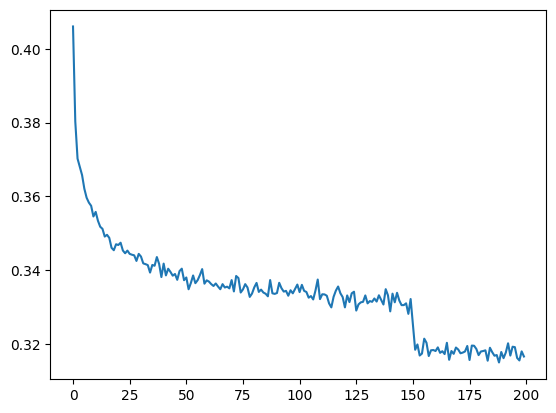

In [25]:
model = initialize_model(n_layers = 2, bn=True, hidden_gain=1, block_size=block_size)
lossi = train(model, Xtr, Ytr)
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [26]:
split_loss(model,'train', datasets)
split_loss(model,'val', datasets)
split_loss(model,'test', datasets)

train 2.0612142086029053
val 2.1071231365203857
test 2.108309268951416


In [27]:
# a simple MLP with an 8 character context length
block_size = 8
datasets = build_dataset(words, context_len=block_size)
Xtr, Ytr = datasets["train"]

Xtr: torch.Size([182516, 8]), Ytr: torch.Size([182516])
Xval: torch.Size([22815, 8]), Yval: torch.Size([22815])
Xte: torch.Size([22815, 8]), Yte: torch.Size([22815])


22097
      0/ 200000: 3.3061
  10000/ 200000: 1.9200
  20000/ 200000: 2.3387
  30000/ 200000: 2.0185
  40000/ 200000: 1.8510
  50000/ 200000: 1.8761
  60000/ 200000: 1.7908
  70000/ 200000: 2.0434
  80000/ 200000: 2.0765
  90000/ 200000: 2.0175
 100000/ 200000: 1.8554
 110000/ 200000: 2.1749
 120000/ 200000: 1.8781
 130000/ 200000: 1.9169
 140000/ 200000: 2.0560
 150000/ 200000: 2.2424
 160000/ 200000: 2.4784
 170000/ 200000: 2.4333
 180000/ 200000: 2.4187
 190000/ 200000: 2.0373


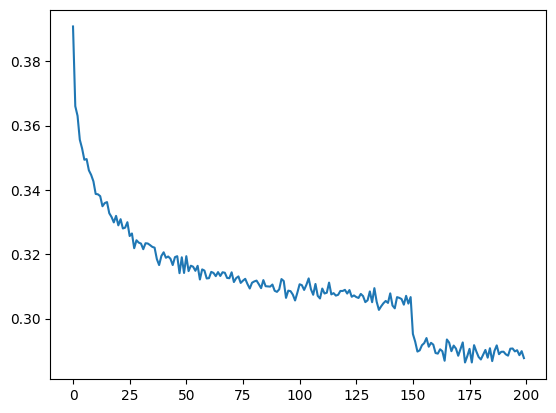

In [28]:
model = initialize_model(n_layers = 2, bn=True, hidden_gain=1, block_size=block_size)
lossi = train(model, Xtr, Ytr)
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [29]:
split_loss(model,'train', datasets)
split_loss(model,'val', datasets)
split_loss(model,'test', datasets)

train 1.9170314073562622
val 2.0273754596710205
test 2.0177745819091797


Context window of 8 characters is a significant improvement over the context length of 3.

# The issue with simple MLP
The problem with the above architecture is is that there is no simple way of making the network bigger in a productive way. We can make the net deepr, but we will still be crushing all the characters into a single layer directly in the beginning. Squashing all the information too fast is not a good idea. WaveNet paper offers a solution:

![WaveNet Architecture](./images/wavenet.png)

In the WaveNet paper the predictions for the next character in the sequence is the function of two previous chars fed. It is not input into a single layer. Two characters are fused at a tinme, in a hierarchial manner, so the information from the context is fed in slowly, allowing for a more intelligent way of combining the input information.

# Getting the dimensions ready for WaveNet

In [30]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb, logits

torch.Size([4, 8])


(tensor([[ 0,  0,  0,  5,  4, 13, 21, 14],
         [ 0,  0,  0,  0, 11,  8,  1, 12],
         [ 0,  0,  0, 11,  1, 13, 15, 18],
         [ 0,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([[ 4.0621,  4.0649, -2.1389, -0.4557,  3.6757,  2.2431, -3.6923,  3.2248,
          -2.7943,  3.7746, -1.1886, -0.6860, -0.1938, -1.7939,  1.0078,  2.4846,
          -4.5507, -3.3043, -1.1912,  0.2015,  1.9191,  0.1051, -2.6113, -2.6806,
          -2.3192,  2.4870, -0.3209],
         [ 1.2044,  3.7815, -0.3622,  0.2209,  2.0199,  4.8632, -1.3770, -4.3899,
          -2.4460,  5.2579, -2.1038,  0.3013,  2.4444, -0.4688, -1.1187,  2.0084,
          -3.3149, -3.2493, -0.8195,  0.5754, -0.5279,  1.9100, -0.2636, -1.2317,
          -5.0822,  3.3484, -1.6999],
         [ 3.6463,  4.7351, -0.4382, -0.7904,  1.3753,  3.8302, -2.4154,  1.1497,
          -1.0256,  4.9031, -0.8527, -0.4368,  0.7799, -2.1781,  0.0970,  1.5006,
          -4.7007, -3.5845,  1.6559, -0.4007,  1.2862,  0.0590, -2.3478, -4.2680,
          -3

Currently the outputs of the embedding layer and the flatten layer are of shape:

In [34]:
model.layers[0].out.shape, model.layers[1].out.shape

(torch.Size([4, 8, 10]), torch.Size([4, 80]))

Esentially we want to have two batch dimensions: the first one for the number of examples in the  batch, and the second one for the fused charcters at each layer (the first one would be 32, the second one would be 2, since two characters would be fused together one at a time). So now the single batch row is just a sequence of consecutive characters:

1,2,3,4,5,6,7,8

But we want to introudce an additional batch component and group the pairs of characters:

(1,2) (3,4) (5,6) (7,8)

We want to process each of the group together. So instead of doing (4x80) @ (80, n_hid), we want to do (4, 4, 20) @ (20, n_hid), where the second 4 is esentially another batch dimension.

For that we need to introduce another layer type:

In [62]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)
        return self.out

    def parameters(self):
        return []

In [63]:
block_size = 8
n_emb = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_emb),   # batch size, sequence length, embedding dimension
    FlattenConsecutive(block_size),          # batch size, sequence length // 8, embedding dimension * 8
    Linear(n_emb*block_size, n_hidden, bias=False),      # batch size, sequence length // 8, n_hidden
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size)    # batch size, sequence length // 2, vocab size
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22097


In [68]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)

In [69]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))


Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
Linear : (4, 4, 27)


In [84]:
block_size = 8
n_fused = 2
n_emb = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(n_fused), Linear(n_emb*n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_fused), Linear(n_hidden*n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(n_fused), Linear(n_hidden*n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [87]:
# a simple MLP with an 8 character context length
block_size = 8
datasets = build_dataset(words, context_len=block_size)
Xtr, Ytr = datasets["train"]

Xtr: torch.Size([182516, 8]), Ytr: torch.Size([182516])
Xval: torch.Size([22815, 8]), Yval: torch.Size([22815])
Xte: torch.Size([22815, 8]), Yte: torch.Size([22815])


      0/ 200000: 3.3093
  10000/ 200000: 1.8534
  20000/ 200000: 2.0280
  30000/ 200000: 2.5692
  40000/ 200000: 1.9857
  50000/ 200000: 2.3154
  60000/ 200000: 1.9239
  70000/ 200000: 1.6353
  80000/ 200000: 1.7010
  90000/ 200000: 2.8158
 100000/ 200000: 1.6710
 110000/ 200000: 2.0660
 120000/ 200000: 2.2694
 130000/ 200000: 2.0435
 140000/ 200000: 2.3545
 150000/ 200000: 2.0080
 160000/ 200000: 2.0970
 170000/ 200000: 1.8539
 180000/ 200000: 1.6989
 190000/ 200000: 2.3002


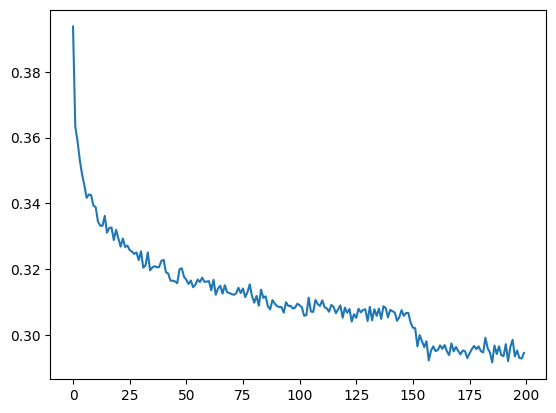

In [88]:
lossi = train(model, Xtr, Ytr)
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [89]:
split_loss(model,'train', datasets)
split_loss(model,'val', datasets)
split_loss(model,'test', datasets)

train 1.9407069683074951
val 2.0272905826568604
test 2.0234243869781494


In [ ]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

# Fixing the Batch Normalization Bug

Current BN  implementation looks like  this:
```
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters for batch norm
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
```

Because we are now operating on tensor with two batch dimensions, calculating the mean and variance along the 0th dimension means that self.mean and self.variance will not be vectors, but matrices. If the input X is (B, T, C), then the mean and variance will be of shape T,C, because only the first dimenision will be reduced. T is the dimension along which we group the numbers to be fused together, and these groups are processed in parallel using the same weights. So we want the mean and variance to be calculated for all the groups together, not separately. Esentially we want to reduce both the first and the second dimension, so that all batch dimension contribute to and share the same statistics. As far as the BN is considred, we do not want to average over the B dimensions, we also want to average over the T dimension. This, however, only applies to the 3 dimensional input case. For a two dimensional input the old reasoning applies.

In [90]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters for batch norm
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
                
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.out * self.gamma + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1 - self.momentum) + xvar * self.momentum
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [91]:
block_size = 8
n_fused = 2
n_emb = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(n_fused), Linear(n_emb*n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_fused), Linear(n_hidden*n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(n_fused), Linear(n_hidden*n_fused, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [92]:
# a simple MLP with an 8 character context length
block_size = 8
datasets = build_dataset(words, context_len=block_size)
Xtr, Ytr = datasets["train"]

Xtr: torch.Size([182516, 8]), Ytr: torch.Size([182516])
Xval: torch.Size([22815, 8]), Yval: torch.Size([22815])
Xte: torch.Size([22815, 8]), Yte: torch.Size([22815])


In [93]:
lossi = train(model, Xtr, Ytr)
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

      0/ 200000: 3.3074
  10000/ 200000: 2.2631
  20000/ 200000: 2.3321
  30000/ 200000: 2.8051
